Árvores de decisão e Florestas Aleatórias

Nesta aula veremos outro algoritmo importante - um algoritmo não paramétrico chamado de florestas aleatórias. As florestas aleatórias são um exemplo de um método ensamble, o que significa que ele se baseia na agregação dos resultados de um conjunto de classificadores mais simples. O resultado surpreendente com tais métodos de conjunto é que a soma pode ser maior que as partes: ou seja, uma votação majoritária entre vários estimadores pode acabar sendo melhor que qualquer um dos estimadores individuais que fazem a votação! Veremos exemplos disso nas seções seguintes. Começamos com as importações padrão:


In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5, 10, 15, 20, 25])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

## Árvores de decisão

As florestas aleatórias são um exemplo de um conjunto de aprendizes construídos sobre árvores de decisão. Por esta razão, vamos começar discutindo as próprias árvores de decisão.

Árvores de decisão são formas extremamente intuitivas de classificar ou rotular objetos: você simplesmente faz uma série de perguntas destinadas a zerar na classificação. Por exemplo, se você quisesse construir uma árvore de decisão para classificar um animal que você encontrou durante uma caminhada, você poderia construir esta aqui mostrada:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

A divisão binária torna isso extremamente eficiente: em uma árvore bem construída, cada pergunta cortará o número de opções pela metade, reduzindo muito rapidamente as opções mesmo entre um grande número de classes. O truque, é claro, vem na decisão das perguntas a serem feitas em cada passo. Em implementações de aprendizagem de máquinas de árvores de decisão, as perguntas geralmente tomam a forma de divisões alinhadas por eixos nos dados: ou seja, cada nó da árvore divide os dados em dois grupos usando um valor de corte dentro de uma das características. Vejamos agora um exemplo disso.



### Criando uma árvore de decisão

Considere os seguintes dados bidimensionais, que têm uma das quatro classes:

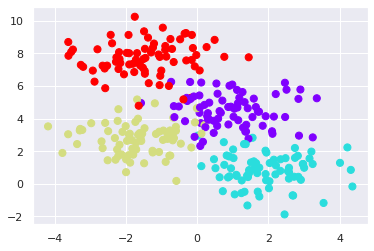

In [23]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Uma simples árvore de decisão construída sobre estes dados dividirá iterativamente os dados ao longo de um ou outro eixo de acordo com algum critério quantitativo, e a cada nível atribuirá o rótulo da nova região de acordo com um voto majoritário de pontos dentro dele. Esta figura apresenta uma visualização dos primeiros quatro níveis de um classificador de árvore de decisão para estes dados:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Observe que após a primeira divisão, cada ponto do ramo superior permanece inalterado, portanto não há necessidade de subdividir mais este ramo. Com exceção dos nós que contêm todos de uma cor, em cada nível cada região é novamente dividida ao longo de uma das duas características.

Este processo de ajustar uma árvore de decisão aos nossos dados pode ser feito em Scikit-Learn com o estimador DecisionTreeClassifier:

In [39]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Agora podemos examinar como é a classificação da árvore de decisão:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


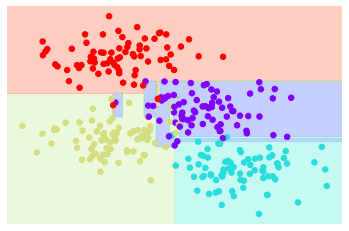

In [31]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [36]:
plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5, 10, 15, 20, 25), value=5)…

Observe que à medida que a profundidade aumenta, tendemos a obter regiões de classificação de forma muito estranha; por exemplo, a uma profundidade de cinco, existe uma região alta e magra de cor roxa entre as regiões amarela e azul. É claro que isto é menos um resultado da verdadeira distribuição intrínseca de dados, e mais um resultado das propriedades particulares de amostragem ou de ruído dos dados. Ou seja, esta árvore de decisão, mesmo a apenas cinco níveis de profundidade, está claramente decorando nossos dados.

### Árvores de decisão e sobre-ajuste

Tal ajuste excessivo acaba sendo uma propriedade geral das árvores de decisão: é muito fácil ir muito fundo na árvore, e assim encaixar detalhes dos dados particulares ao invés das propriedades gerais das distribuições das quais são extraídas.
Outra maneira de ver este ajuste excessivo é olhar para modelos treinados em diferentes subconjuntos de dados - por exemplo, nesta figura, treinamos duas árvores diferentes, cada uma na metade dos dados originais:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

É claro que em alguns lugares, as duas árvores produzem resultados consistentes (por exemplo, nos quatro cantos), enquanto em outros lugares, as duas árvores dão classificações muito diferentes (por exemplo, nas regiões entre dois aglomerados quaisquer).
A observação chave é que as inconsistências tendem a acontecer onde a classificação é menos certa, e assim, usando informações de *ambas* destas árvores, podemos chegar a um resultado melhor!

In [41]:
randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

Assim como a utilização de informações de duas árvores melhora nossos resultados, podemos esperar que a utilização de informações de muitas árvores melhore ainda mais nossos resultados.

## Conjunto de classificadores: Florestas Aleatórias

Esta noção - que múltiplos estimadores que decoram os dados podem ser combinados para reduzir o efeito deste sobreajuste - é o que está por trás de um método de conjunto chamado de *bagging*.

O bagging faz uso de um conjunto de classificadores paralelos, cada um dos quais se ajusta demais aos dados, e calcula a média dos resultados para encontrar uma classificação melhor.

Um conjunto de árvores de decisão aleatória é conhecido como **floresta aleatorias**.

Este tipo de classificação de bagging pode ser feito manualmente utilizando o meta-estimador "BaggingClassifier" da Scikit-Learn, como mostrado aqui:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


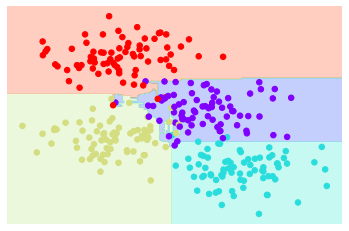

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

Neste exemplo, randomizamos os dados ajustando cada estimador com um subconjunto aleatório de 80% dos pontos de treinamento. Na prática, as árvores de decisão são mais efetivamente randomizadas injetando alguma estocasticidade na forma como as divisões são escolhidas: desta forma todos os dados contribuem para o ajuste a cada vez, mas os resultados do ajuste ainda têm a aleatoriedade desejada. 

Por exemplo, ao determinar qual característica a ser dividida, a árvore aleatorizada pode selecionar entre as várias características superiores. Você pode ler mais detalhes técnicos a respeito destas estratégias de randomização na documentação Scikit-Learn e referências dentro dela.

No Scikit-Learn, tal conjunto otimizado de árvores de decisão aleatória é implementado no estimador RandomForestClassifier, que cuida de toda a aleatoriedade automaticamente. Tudo o que você precisa fazer é selecionar um número de estimadores, e ele se ajustará muito rapidamente (em paralelo, se desejado) ao conjunto de árvores:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


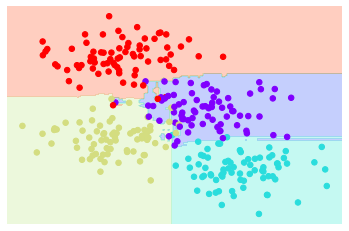

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que, ao calcularmos a média de mais de 100 modelos perturbados aleatoriamente, acabamos com um modelo geral que está muito mais próximo de nossa intuição sobre como o espaço de parâmetros deve ser dividido.

## Random Forest Regression

Na seção anterior, consideramos as florestas aleatórias dentro do contexto de classificação.
As florestas aleatórias também podem ser feitas para funcionar no caso de regressão (ou seja, variáveis contínuas ao invés de categóricas). O estimador a ser utilizado para isso é o ``RandomForestRegressor'', e a sintaxe é muito semelhante ao que vimos anteriormente.

Considere os seguintes dados, obtidos a partir da combinação de uma oscilação rápida e lenta:

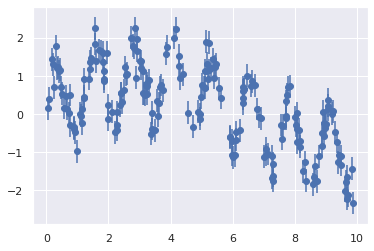

In [44]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Usando o regressor florestal aleatório, podemos encontrar a curva de melhor ajuste da seguinte forma:

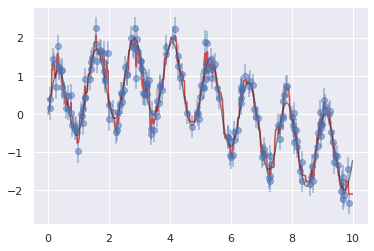

In [51]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aqui o modelo verdadeiro é mostrado na curva cinza lisa, enquanto o modelo florestal aleatório é mostrado pela curva vermelha recortada. Como você pode ver, o modelo florestal aleatório não paramétrico é flexível o suficiente para se ajustar aos dados de múltiplos períodos, sem a necessidade de especificarmos um modelo de múltiplos períodos!

## Examplo: Florestas aleatórias para classificar dígitos


In [52]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Vamos visualizar uma porção dos dados



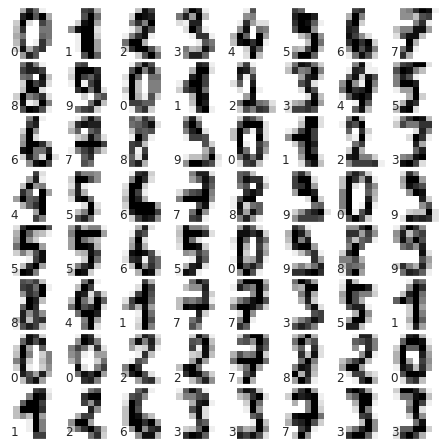

In [53]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos rápidamente classificar os digitos usando as florestas aleatorias 

In [54]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Classification Report

In [18]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

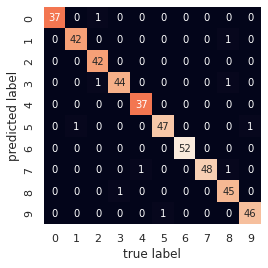

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');